In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Dataset.zip


Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Val/62/161.png  
  inflating: Dataset/Val/62/162.png  
  inflating: Dataset/Val/62/163.png  
  inflating: Dataset/Val/62/164.png  
  inflating: Dataset/Val/62/165.png  
  inflating: Dataset/Val/62/166.png  
  inflating: Dataset/Val/62/167.png  
  inflating: Dataset/Val/62/168.png  
 extracting: Dataset/Val/62/169.png  
  inflating: Dataset/Val/62/17.png   
 extracting: Dataset/Val/62/170.png  
 extracting: Dataset/Val/62/171.png  
  inflating: Dataset/Val/62/172.png  
  inflating: Dataset/Val/62/173.png  
  inflating: Dataset/Val/62/174.png  
 extracting: Dataset/Val/62/175.png  
  inflating: Dataset/Val/62/176.png  
  inflating: Dataset/Val/62/177.png  
  inflating: Dataset/Val/62/178.png  
  inflating: Dataset/Val/62/179.png  
  inflating: Dataset/Val/62/18.png   
  inflating: Dataset/Val/62/180.png  
  inflating: Dataset/Val/62/181.png  
  inflating: Dataset/Val/62/182.png  
  inflating: Dataset/Val/62/183.png  

In [3]:
!pip install pytorch_lightning --quiet
!pip install matplotlib
!pip install wandb --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.6 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
import pytorch_lightning as pl
import torchmetrics
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
from pytorch_lightning.loggers import WandbLogger

import wandb

In [5]:
wandb.login(key='8bef51a7725732df55eb35140d3e754b77503112')

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [6]:
class ResizeAndPad:
    def __init__(self, size, fill=0):
        self.size = size
        self.fill = fill

    def __call__(self, image):
        # Resize the image while maintaining its aspect ratio

        width, height = image.size
        assert height != 0 and width != 0
        aspect_ratio = width / height
        target_width, target_height = self.size

        if aspect_ratio > 1:
            new_width = (target_width)
            new_height = math.ceil(target_width / aspect_ratio)
        else:
            new_width = math.ceil(target_height * aspect_ratio)
            new_height = int(target_height)

        assert new_height > 0, f"New width ({new_width}) original size ({image.size})"
        assert new_width > 0, f"New height ({new_width}) original size ({image.size})"
        resized_image = image.resize((new_width, new_height), Image.ANTIALIAS)

        # Create a new image with the desired size and fill it with the specified color
        new_image = Image.new("RGB", self.size, (self.fill, self.fill, self.fill))

        # Paste the resized image into the center of the new image
        left = (target_width - new_width) // 2
        top = (target_height - new_height) // 2
        new_image.paste(resized_image, (left, top))

        return new_image


In [7]:
class HungarianDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_folder = ImageFolder(root=root_dir, transform=transform)

    def __len__(self):
        return len(self.image_folder)

    def __getitem__(self, idx):
        return self.image_folder[idx]

In [8]:
class HungarianHelperDataModule(pl.LightningDataModule):
    '''organize the data pipeline from accessing the data to loading it using PyTorch dataloaders'''

    def __init__(self, batch_size, image_dims, data_dir: str = './', num_workers = 2):
        super().__init__()
        self.data_dir = data_dir + "Train/"
        self.val_dir = data_dir + "Val/"
        self.test_dir = data_dir + "Test/"
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.dims = image_dims
        # Define the transformation to resize images to 32x32 and normalize it
        self.train_transform = transforms.Compose([
            transforms.RandomGrayscale(p=0.2),                                  # Convert to grayscale with probability 0.2
            transforms.RandomRotation(22.5),                                     # Random rotation
            ResizeAndPad((image_dims[1],image_dims[2]),fill=0),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])
        self.val_transform = transforms.Compose([
            ResizeAndPad((image_dims[1],image_dims[2]),fill=0),
            transforms.ToTensor(),  # Convert the image to a PyTorch tensor
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize the pixel values
        ])

        self.num_classes = 70

    # PyTorch dataset instances
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train_dataset = HungarianDataset(self.data_dir, transform=self.train_transform)
            self.class_labels = self.train_dataset.image_folder.classes
            assert self.num_classes == len(self.train_dataset.image_folder.classes) # Make sure all classes are read

            self.val_dataset = HungarianDataset(self.val_dir, transform=self.val_transform)
            self.class_labels = self.val_dataset.image_folder.classes
            assert self.num_classes == len(self.val_dataset.image_folder.classes) # Make sure all classes are read

        if stage == 'test' or stage is None:
            self.test_dataset = HungarianDataset(self.test_dir, transform=self.val_transform)
            self.class_labels = self.test_dataset.image_folder.classes
            assert self.num_classes == len(self.test_dataset.image_folder.classes) # Make sure all classes are read

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

In [9]:
# base class is the LightningModule, on which we build our custom model:
# - initialization: __init__ and setup()
# - train loop: training_step()
# - validation loop: validation_step()
# - test loop: test_step()
# - prediction loop: predict_step() - by default, runs the forward() method
# - optimizers and LR schedulers: configure_optimizers()

from torchmetrics.classification import MulticlassConfusionMatrix
class OCRFeedForwardNet(pl.LightningModule):
    def __init__(self, batch_size, image_dims, class_labels, num_classes, lr, dropout = 0.25, batchNorm = True, width = 32):
      super(OCRFeedForwardNet, self).__init__()
      self.save_hyperparameters()
      self.lr = lr
      self.num_classes = num_classes
      self.dims = image_dims
      self.batch_size = batch_size
      num_features = image_dims[0]*image_dims[1]*image_dims[2]
      self.class_labels = class_labels
      self.new_epoch = False
      self.new_training = False
      #self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.confusion_matrix = MulticlassConfusionMatrix(num_classes=self.num_classes).to(torch.device("cuda"))


      self.layers = nn.Sequential(
          torch.nn.Conv2d(in_channels=3, out_channels=width, kernel_size=3, stride=1, padding=1),
          torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=1, padding=1),
          torch.nn.ReLU(),
          torch.nn.BatchNorm2d(width),
          torch.nn.AdaptiveAvgPool2d(output_size=image_dims[1]//2),
          torch.nn.Conv2d(in_channels=width, out_channels=width*2, kernel_size=3, stride=1, padding=1),
          torch.nn.ReLU(),
          torch.nn.BatchNorm2d(width*2),
          torch.nn.AdaptiveAvgPool2d(output_size=image_dims[1]//4),
          torch.nn.Conv2d(in_channels=width*2, out_channels=width*4, kernel_size=3, stride=1, padding=1),
          torch.nn.ReLU(),
          torch.nn.BatchNorm2d(width*4),
          torch.nn.AdaptiveAvgPool2d(output_size=image_dims[1]//8),
          torch.nn.Conv2d(in_channels=width*4, out_channels=width*8, kernel_size=3, stride=1, padding=1),
          torch.nn.ReLU(),
          torch.nn.BatchNorm2d(width*8),
          torch.nn.AdaptiveAvgPool2d(output_size=image_dims[1]//16),
          torch.nn.Conv2d(in_channels=width*8, out_channels=width*16, kernel_size=3, stride=1, padding=1),
          torch.nn.ReLU(),
          torch.nn.BatchNorm2d(width*16),
          torch.nn.AdaptiveAvgPool2d(output_size=image_dims[1]//32),
          torch.nn.Flatten(),
          torch.nn.Linear(in_features=width*16, out_features=width*32),
          torch.nn.ReLU(),
          torch.nn.Linear(in_features=width*32, out_features=num_classes),
          torch.nn.Softmax()

      )

#      modules = []
#      modules.append(nn.Conv2d(in_channels=3, out_channels=layer_depth[0], kernel_size=3, stride = 1, padding = 1))
#      for i in range(1,len(layer_depth)):
#          modules.append(nn.AdaptiveMaxPool2d(output_size = int((image_dims[1]*layer_depth[0])/layer_depth[i])))
#          modules.append(nn.Conv2d(in_channels=layer_depth[i - 1], out_channels=layer_depth[i], kernel_size=3, stride = 1, padding = 1))
#          if batchNorm:
#            modules.append(nn.BatchNorm2d(layer_depth[i]))
#          modules.append(nn.ReLU())
#          modules.append(nn.Dropout(dropout))

#      modules.append(nn.Flatten())
#      num_points = int((image_dims[1]*image_dims[1]*layer_depth[0]*layer_depth[0])//layer_depth[-1])
#      #modules.append(nn.Linear(in_features=num_points, out_features=num_points*fc_hidden))
#      #modules.append(nn.ReLU())
#      modules.append(nn.Linear(in_features=num_points, out_features=num_classes))
#      modules.append(nn.Softmax())
#      print(modules)
#      self.layers = nn.Sequential(*modules)

      print(self.layers)
      self.total_params = sum(p.numel() for p in self.layers.parameters())

      self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)


    # forward propagation
    def forward(self, x):
      return self.layers(x)

    # one step of training
    def training_step(self, batch, batch_idx):
      self.new_epoch = True
      loss, acc = self._shared_eval_step(batch, batch_idx)
      metrics = {"acc": acc, "loss": loss}
      self.log_dict(metrics, on_epoch=True)
      return metrics

    # one step of validation
    def validation_step(self, batch, batch_idx):
      self.new_training = True
      if self.new_epoch:
        self.confusion_matrix = MulticlassConfusionMatrix(num_classes=self.num_classes).to(torch.device("cuda"))
        self.new_epoch = False
      loss, acc = self._shared_eval_step(batch, batch_idx, update_confusion_matrix=True)
      metrics = {"val_acc": acc, "val_loss": loss}
      #wandb.log({"val_loss": loss})
      self.log_dict(metrics, prog_bar=True)
      return metrics

    # one step of test
    def test_step(self, batch, batch_idx):
      if self.new_training:
        self.confusion_matrix = MulticlassConfusionMatrix(num_classes=self.num_classes).to(torch.device("cuda"))
        self.new_training = False
      loss, acc = self._shared_eval_step(batch, batch_idx, update_confusion_matrix=True)
      metrics = {"test_acc": acc, "test_loss": loss}
      self.log_dict(metrics)
      return metrics

    def _shared_eval_step(self, batch, batch_idx, update_confusion_matrix=False):
      x, y = batch
      y_hat = self(x).squeeze() # squeeze the output to match the target shape
      loss =  torch.nn.functional.cross_entropy(y_hat, y)
      acc =  self.accuracy(y_hat, y)
      if update_confusion_matrix:
        self.confusion_matrix.update(y_hat, y)
      return loss, acc

    # we use the AdamW optimizer
    def configure_optimizers(self):
      return torch.optim.AdamW(self.parameters(), lr=self.lr)


In [10]:
# class for visualizing one batch of validation images along with predicted and rall class label
class ImagePredictionLogger(pl.Callback):
    def __init__(self, val_samples, num_samples=32):
        super().__init__()
        self.val_imgs, self.val_labels = val_samples
        self.val_imgs = self.val_imgs[:num_samples]
        self.val_labels = self.val_labels[:num_samples]

    def on_validation_epoch_end(self, trainer, pl_module):
        val_imgs = self.val_imgs.to(device=pl_module.device)
        logits = pl_module(val_imgs)
        preds = torch.argmax(logits, 1)

        trainer.logger.experiment.log({
            "examples": [wandb.Image(x, caption=f"Pred:{pred}, Label:{y}")
                            for x, pred, y in zip(val_imgs, preds, self.val_labels)],
            "global_step": trainer.global_step
            })

In [20]:
from wandb.env import CONFIG_DIR

sweep_config = {
    "method": "bayes",
    "name": "sweep",
    "metric": {"goal": "minimize", "name": "val_loss"},
    "parameters": {
        "batch_size": {"values": [256]},
        "image_dims": {"values": [32]},
        "batch_norm": {"values": [True]},
        "lr": {"max": 0.002, "min": 0.001},
        "embedding_depth":{"values": [16]},
    },
}

In [21]:
import matplotlib.pyplot as plt
import random


def visualize_data(dm):
  # Access the train dataset
  visualize_train_dataset = dm.train_dataset
  visualize_labels = dm.class_labels

  # Create a plot to display 5 random images
  fig, axes = plt.subplots(1, 5, figsize=(15, 5))
  fig.suptitle("Random Images from the Hungarian Dataset")

  for i in range(5):
      # Randomly select an image and its label
      idx = random.randint(0, len(visualize_train_dataset) - 1)
      sample, label = visualize_train_dataset[idx]

      # Convert the tensor to a NumPy array and unnormalize it
      sample = sample.numpy().transpose((1, 2, 0))
      sample = 0.5 * sample + 0.5  # Unnormalize

      # Display the image and its label

      ax = axes[i]
      ax.imshow(sample)
      ax.set_title(f"Class: {visualize_labels[label]}")

  # Show the plot
  plt.show()

In [22]:
import warnings

# Temporarily suppress deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Your code that triggers deprecation warnings

# Re-enable deprecation warnings (if needed)
#warnings.filterwarnings("default", category=DeprecationWarning)


In [23]:
epochs = 500
wandb_logger = WandbLogger(project='HungarianHelper', job_type='train', log_model="all")
sweep_id = wandb.sweep(sweep=sweep_config, project="HungarianHelper")
def train_model():
  wandb_logger = WandbLogger(project='HungarianHelper', job_type='train', log_model="all")
  sweep_id = wandb.sweep(sweep=sweep_config, project="HungarianHelper")
  wandb.init(project="HungarianHelper")
  Runname = wandb.run.name

  config = wandb.config
  image_dims = (3,config.image_dims,config.image_dims)
  learning_rate = config.lr
  dropout = 0.0
  activate_bn = config.batch_norm
  batch_size = config.batch_size
  embedding_depth = config.embedding_depth

  # we instantiate our model
  dm = HungarianHelperDataModule(batch_size  = batch_size, image_dims = image_dims, data_dir = "/content/Dataset/" )
  dm.setup()
  visualize_data(dm)
  model = OCRFeedForwardNet(batch_size = batch_size, image_dims = image_dims, class_labels = dm.class_labels, num_classes = 70, lr = learning_rate, dropout = dropout, batchNorm = activate_bn, width = embedding_depth)
  wandb_logger.watch(model)
  # we use the ModelCheckpoint callback to save the best model
  checkpoint_callback = pl.callbacks.ModelCheckpoint(
      monitor='val_loss',
      dirpath = '/content/drive/MyDrive/checkpoints_HungarianHelper/' + Runname + '/',
      filename = 'best_model',
      )

  early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=False, mode="min")
  ### WandB
  # grab samples to log predictions on
  samples = next(iter(dm.val_dataloader()))
  trainer = pl.Trainer(max_epochs=epochs,
                    logger=wandb_logger,
                    callbacks=[checkpoint_callback, early_stop_callback],
                    default_root_dir="/content/drive/MyDrive/checkpoints_HungarianHelper/" + Runname + "/"
              )
  trainer.fit(model, dm.train_dataloader(), dm.val_dataloader())
  f,ax = plt.subplots(1,1,figsize=(50,50))
  model.confusion_matrix.plot(ax=ax)

  trainer.test(dataloaders=dm.test_dataloader())
  f,ax = plt.subplots(1,1,figsize=(50,50))
  model.confusion_matrix.plot(ax=ax)



Create sweep with ID: l4ffx5gn
Sweep URL: https://wandb.ai/msc_bme/HungarianHelper/sweeps/l4ffx5gn


wandb: Agent Starting Run: 608ovqkc with config:
wandb: 	batch_norm: True
wandb: 	batch_size: 256
wandb: 	embedding_depth: 16
wandb: 	image_dims: 32
wandb: 	lr: 0.0018967334017575813


Create sweep with ID: xwq3t0rp
Sweep URL: https://wandb.ai/msc_bme/HungarianHelper/sweeps/xwq3t0rp


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


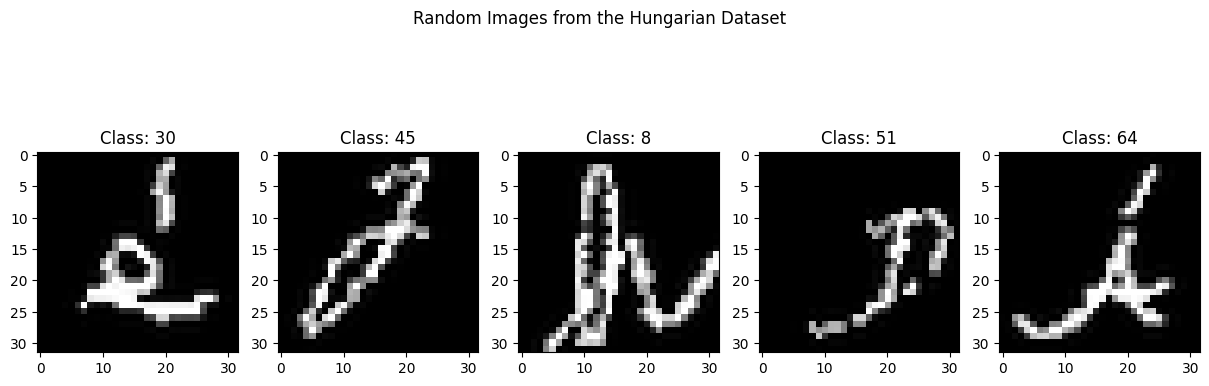

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): ReLU()
  (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): AdaptiveAvgPool2d(output_size=16)
  (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): AdaptiveAvgPool2d(output_size=8)
  (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): AdaptiveAvgPool2d(output_size=4)
  (13): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU()
  (15): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (16): AdaptiveAvgPool2d(output_size=2)
  (17): Conv2d(128, 256, kernel_size=(3, 3), strid

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type                      | Params
---------------------------------------------------------------
0 | confusion_matrix | MulticlassConfusionMatrix | 0     
1 | layers           | Sequential                | 563 K 
2 | accuracy         | MulticlassAccuracy        | 0     
---------------------------------------------------------------
563 K     Trainable params
0         Non-trainable params
563 K     Total params
2.254     Total estimated model params size (MB)
wandb: WARNING Config item 'batch_size' was locked by '

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:

wandb.agent(sweep_id, function=train_model, count=10)

In [ ]:
wandb.finish()